In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('mode.chained_assignment', None)
from sklearn.linear_model import LinearRegression
import random
from itertools import combinations

plt.style.use('ggplot')

# loading raw csv data for 1st and 2nd ballot in each year

df1_2005 = pd.read_csv("./2005/1st-ballot-2005.csv")
df2_2005 = pd.read_csv("./2005/2nd-ballot-2005.csv")
df1_2010 = pd.read_csv("./2010/1st-ballot-2010.csv")
df2_2010 = pd.read_csv("./2010/2nd-ballot-2010.csv")
df1_2015 = pd.read_csv("./2015/1st-ballot-2015.csv")
df2_2015 = pd.read_csv("./2015/2nd-ballot-2015.csv")
df1_2020 = pd.read_csv("./2020/1st-ballot-2020.csv")

# adding turnout column to the data 

def add_turnout_column(df):
    df["turnout"] = df["total_votes"] / df["eligible_voters"]
    df = df[list(df.columns)[:4] + ["turnout"] + list(df.columns)[4:-1]]
    return df

df1_2005 = add_turnout_column(df1_2005) 
df2_2005 = add_turnout_column(df2_2005)
df1_2010 = add_turnout_column(df1_2010)
df2_2010 = add_turnout_column(df2_2010)
df1_2015 = add_turnout_column(df1_2015)
df2_2015 = add_turnout_column(df2_2015)
df1_2020 = add_turnout_column(df1_2020)

# adding % results of each candidate with respect to total voters and eligible voters

def add_perc_results(df):
    no_of_candidates = df.shape[1] - 5
    candidate_list = list(df.columns)[-no_of_candidates:]
    for candidate in candidate_list:
        df[candidate + "_votes_perc"] = df[candidate] / df["total_votes"]
        df[candidate + "_eligible_perc"] = df[candidate] / df["eligible_voters"]
    
    return df

df1_2005 = add_perc_results(df1_2005) 
df2_2005 = add_perc_results(df2_2005)
df1_2010 = add_perc_results(df1_2010)
df2_2010 = add_perc_results(df2_2010)
df1_2015 = add_perc_results(df1_2015)
df2_2015 = add_perc_results(df2_2015)
df1_2020 = add_perc_results(df1_2020)

# Adding the result of candidates, who didn't make it to the 2nd ballot

df1_2005["Other_eligible_perc"] = df1_2005["turnout"] - df1_2005["Kaczynski_eligible_perc"] - df1_2005["Tusk_eligible_perc"]
df1_2010["Other_eligible_perc"] = df1_2010["turnout"] - df1_2010["Kaczynski_eligible_perc"] - df1_2010["Komorowski_eligible_perc"]
df1_2015["Other_eligible_perc"] = df1_2015["turnout"] - df1_2015["Duda_eligible_perc"] - df1_2015["Komorowski_eligible_perc"]
df1_2020["Other_eligible_perc"] = df1_2020["turnout"] - df1_2020["Duda_eligible_perc"] - df1_2020["Trzaskowski_eligible_perc"]



In [62]:
def result_increase_reg(target_candidate, comaprison_candidate, year, xlim=None, ylim=None, normalized=False, color=None):
    
    elections = {2005 : [df1_2005, df2_2005], 
                 2010 : [df1_2010, df2_2010],
                 2015 : [df1_2015, df2_2015]}
    
    increase = np.array(elections[year][1][f"{target_candidate}_eligible_perc"] - elections[year][0][f"{target_candidate}_eligible_perc"])
    before_increase = np.array(elections[year][0][f"{target_candidate}_eligible_perc"])
    comparison = np.array(elections[year][0][f"{comaprison_candidate}_eligible_perc"])
    
    if normalized:
        comparison /= np.mean(comparison)
        increase /= np.mean(before_increase)
    
    
    plt.xlabel(f"{comaprison_candidate}'s result {year}")
    plt.ylabel(f"{target_candidate}'s increase between ballots {year}")
    
    plt.scatter(comparison, increase, c=color)
    
    if xlim != None:
        plt.xlim(*xlim)
    if ylim != None:
        plt.ylim(*ylim)
    
    model = LinearRegression()
    model.fit(comparison.reshape(381, 1), increase)
    
    plt.title(f"Y = {np.round(model.intercept_, 3)} + {np.round(model.coef_[0], 3)} X")
    plt.show()
    

def result_result_reg(target_candidate, comaprison_candidate, year, xlim=None, ylim=None, normalized=False):
    
    elections = {2005 : [df1_2005], 
                 2010 : [df1_2010],
                 2015 : [df1_2015],
                 2020 : [df1_2020]}
    
    result = np.array(elections[year][0][f"{target_candidate}_eligible_perc"])
    comparison = np.array(elections[year][0][f"{comaprison_candidate}_eligible_perc"])
    
    if normalized:
        comparison /= np.mean(comparison)
        result /= np.mean(result)
    
    plt.title(f"{year}: {comaprison_candidate}(result) --> {target_candidate}(result)")
    
    plt.scatter(comparison, result)
    if xlim != None:
        plt.xlim(*xlim)
    if ylim != None:
        plt.ylim(*ylim)
    
    model = LinearRegression()
    model.fit(comparison.reshape(381, 1), result)
    print(f"intercept:{model.intercept_} coef:{model.coef_}")

    plt.show()
    
    return model.coef_[0]
    
    
def compare_increase(target_candidate, previous_candidate, year, xlim=None, line=False):
    
    elections = {2005 : [df1_2005, df2_2005], 
                 2010 : [df1_2010, df2_2010],
                 2015 : [df1_2015, df2_2015]}
    
    first_increase = np.array(elections[year - 5][1][f"{previous_candidate}_eligible_perc"] - elections[year - 5][0][f"{previous_candidate}_eligible_perc"])
    second_increase = np.array(elections[year][1][f"{target_candidate}_eligible_perc"] - elections[year][0][f"{target_candidate}_eligible_perc"])
    
    plt.scatter(first_increase, second_increase)
    plt.title(f"{year}: {previous_candidate} --> {target_candidate}")
    if xlim != None:
        plt.xlim(*xlim)
        
    #if True:
    #    plt.plot([0,1], [0,1])
    #    plt.ylim(min(second_increase), max(second_increase))
        
    model = LinearRegression()
    model.fit(first_increase.reshape(381, 1), second_increase)
    print(f"intercept:{model.intercept_} coef:{model.coef_}")
    

    plt.show()
    

def calculate_rmse(prediction, actual):
    return np.sqrt(np.mean((actual - prediction) ** 2))
    

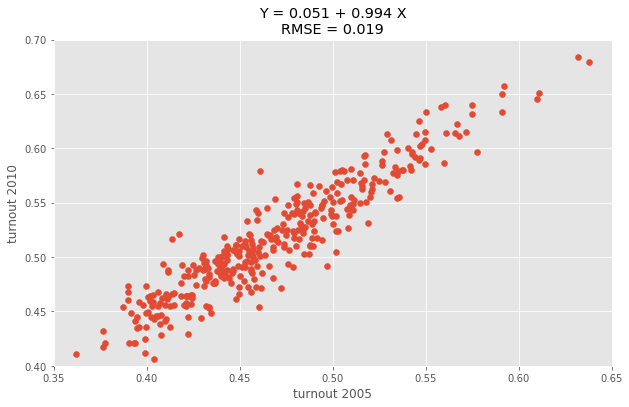

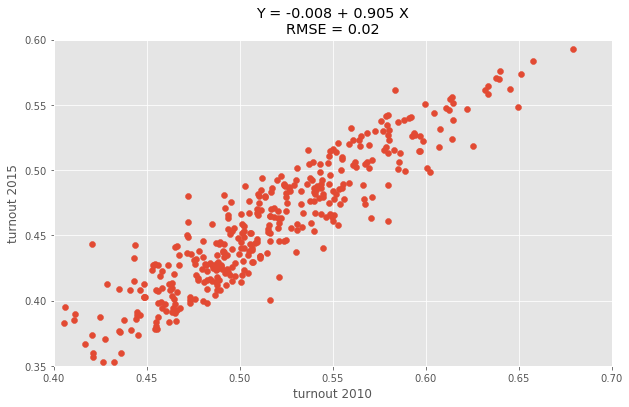

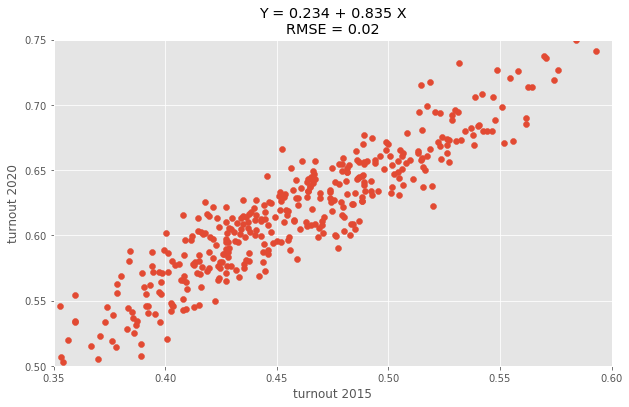

In [30]:
turnout1_2005 = np.array(df1_2005["turnout"])
turnout1_2010 = np.array(df1_2010["turnout"])
turnout1_2015 = np.array(df1_2015["turnout"])
turnout1_2020 = np.array(df1_2020["turnout"])

plt.figure(figsize=(10, 6))
model = LinearRegression()
model.fit(turnout1_2005.reshape(381, 1), turnout1_2010)
turnout_prediction = model.predict(turnout1_2005.reshape(381, 1))
rmse = calculate_rmse(turnout_prediction, turnout1_2010)
plt.title(f"Y = {np.round(model.intercept_, 3)} + {np.round(model.coef_[0], 3)} X\nRMSE = {np.round(rmse, 3)}")
plt.scatter(turnout1_2005, turnout1_2010)
plt.xlim(0.35, 0.65)
plt.ylim(0.4, 0.7)
plt.ylabel("turnout 2010")
plt.xlabel("turnout 2005")
plt.show()

plt.figure(figsize=(10, 6))
model = LinearRegression()
model.fit(turnout1_2010.reshape(381, 1), turnout1_2015)
turnout_prediction = model.predict(turnout1_2010.reshape(381, 1))
rmse = calculate_rmse(turnout_prediction, turnout1_2015)
plt.title(f"Y = {np.round(model.intercept_, 3)} + {np.round(model.coef_[0], 3)} X\nRMSE = {np.round(rmse, 3)}")
plt.scatter(turnout1_2010, turnout1_2015)
plt.xlim(0.4, 0.7)
plt.ylim(0.35, 0.6)
plt.ylabel("turnout 2015")
plt.xlabel("turnout 2010")
plt.show()

plt.figure(figsize=(10, 6))
model = LinearRegression()
model.fit(turnout1_2015.reshape(381, 1), turnout1_2020)
turnout_prediction = model.predict(turnout1_2015.reshape(381, 1))
rmse = calculate_rmse(turnout_prediction, turnout1_2020)
plt.title(f"Y = {np.round(model.intercept_, 3)} + {np.round(model.coef_[0], 3)} X\nRMSE = {np.round(rmse, 3)}")
plt.scatter(turnout1_2015, turnout1_2020)
plt.xlim(0.35, 0.6)
plt.ylim(0.5, 0.75)
plt.ylabel("turnout 2020")
plt.xlabel("turnout 2015")
plt.show()

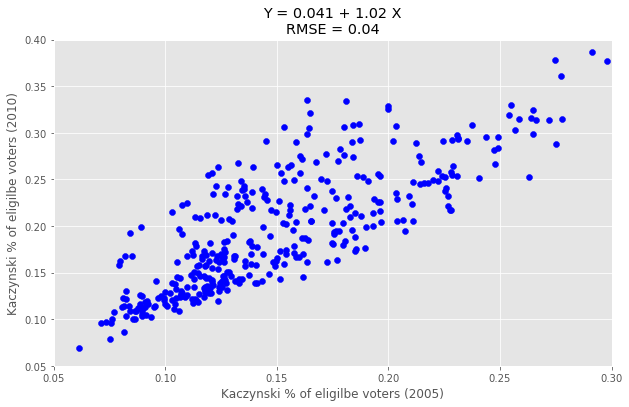

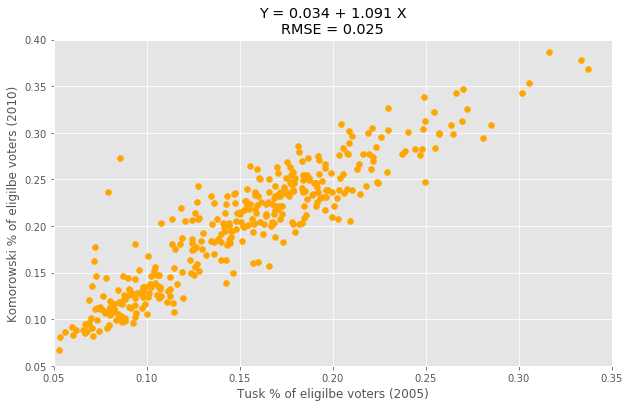

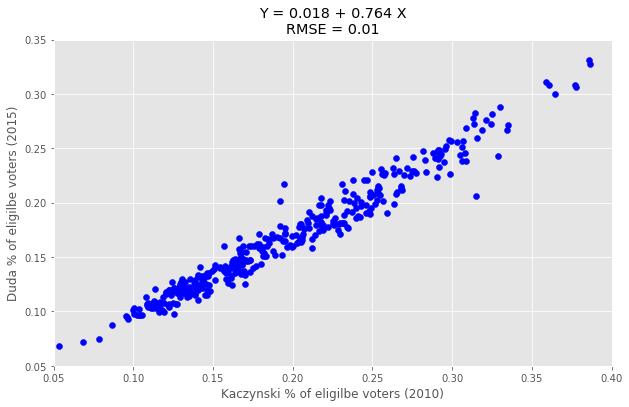

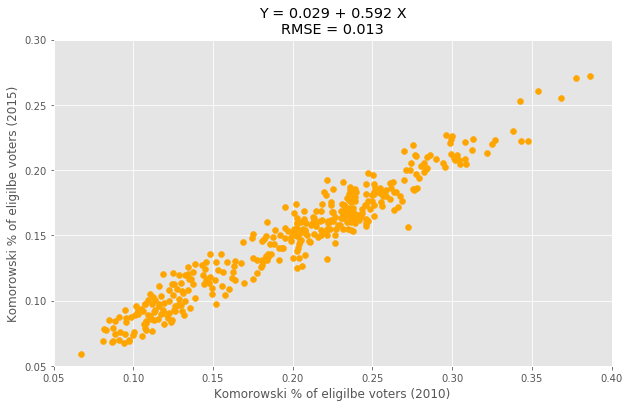

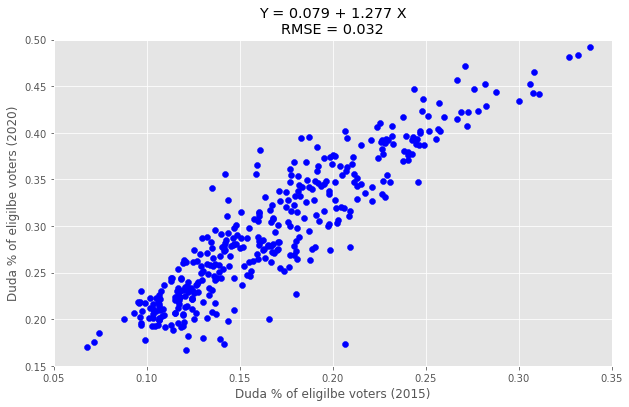

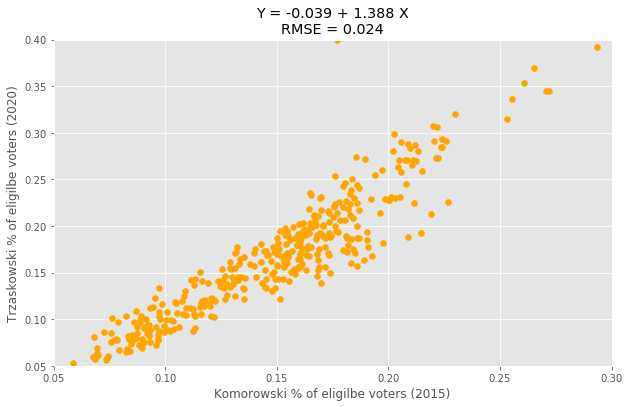

In [44]:
pis_05 = np.array(df1_2005["Kaczynski_eligible_perc"])
pis_10 = np.array(df1_2010["Kaczynski_eligible_perc"])
pis_15 = np.array(df1_2015["Duda_eligible_perc"])
pis_20 = np.array(df1_2020["Duda_eligible_perc"])

po_05 = np.array(df1_2005["Tusk_eligible_perc"])
po_10 = np.array(df1_2010["Komorowski_eligible_perc"])
po_15 = np.array(df1_2015["Komorowski_eligible_perc"])
po_20 = np.array(df1_2020["Trzaskowski_eligible_perc"])

oth_05 = np.array(df1_2005["Other_eligible_perc"])
oth_10 = np.array(df1_2010["Other_eligible_perc"])
oth_15 = np.array(df1_2015["Other_eligible_perc"])
oth_20 = np.array(df1_2020["Other_eligible_perc"])



plt.figure(figsize=(10, 6))
model = LinearRegression()
model.fit(pis_05.reshape(381, 1), pis_10)
support_prediction = model.predict(pis_05.reshape(381, 1))
rmse = calculate_rmse(support_prediction, pis_10)
plt.title(f"Y = {np.round(model.intercept_, 3)} + {np.round(model.coef_[0], 3)} X\nRMSE = {np.round(rmse, 3)}")
plt.xlabel("Kaczynski % of eligilbe voters (2005)")
plt.ylabel("Kaczynski % of eligilbe voters (2010)")
plt.xlim(0.05, 0.3)
plt.ylim(0.05, 0.4)
plt.scatter(pis_05, pis_10, c="blue")
plt.show()

plt.figure(figsize=(10, 6))
model = LinearRegression()
model.fit(po_05.reshape(381, 1), po_10)
support_prediction = model.predict(po_05.reshape(381, 1))
rmse = calculate_rmse(support_prediction, po_10)
plt.title(f"Y = {np.round(model.intercept_, 3)} + {np.round(model.coef_[0], 3)} X\nRMSE = {np.round(rmse, 3)}")
plt.xlabel("Tusk % of eligilbe voters (2005)")
plt.ylabel("Komorowski % of eligilbe voters (2010)")
plt.xlim(0.05, 0.35)
plt.ylim(0.05, 0.4)
plt.scatter(po_05, po_10, c="orange")
plt.show()

plt.figure(figsize=(10, 6))
model = LinearRegression()
model.fit(pis_10.reshape(381, 1), pis_15)
support_prediction = model.predict(pis_10.reshape(381, 1))
rmse = calculate_rmse(support_prediction, pis_15)
plt.title(f"Y = {np.round(model.intercept_, 3)} + {np.round(model.coef_[0], 3)} X\nRMSE = {np.round(rmse, 3)}")
plt.xlabel("Kaczynski % of eligilbe voters (2010)")
plt.ylabel("Duda % of eligilbe voters (2015)")
plt.xlim(0.05, 0.4)
plt.ylim(0.05, 0.35)
plt.scatter(pis_10, pis_15, c="blue")
plt.show()

plt.figure(figsize=(10, 6))
model = LinearRegression()
model.fit(po_10.reshape(381, 1), po_15)
support_prediction = model.predict(po_10.reshape(381, 1))
rmse = calculate_rmse(support_prediction, po_15)
plt.title(f"Y = {np.round(model.intercept_, 3)} + {np.round(model.coef_[0], 3)} X\nRMSE = {np.round(rmse, 3)}")
plt.xlabel("Komorowski % of eligilbe voters (2010)")
plt.ylabel("Komorowski % of eligilbe voters (2015)")
plt.xlim(0.05, 0.4)
plt.ylim(0.05, 0.3)
plt.scatter(po_10, po_15, c="orange")
plt.show()

plt.figure(figsize=(10, 6))
model = LinearRegression()
model.fit(pis_15.reshape(381, 1), pis_20)
support_prediction = model.predict(pis_15.reshape(381, 1))
rmse = calculate_rmse(support_prediction, pis_20)
plt.title(f"Y = {np.round(model.intercept_, 3)} + {np.round(model.coef_[0], 3)} X\nRMSE = {np.round(rmse, 3)}")
plt.xlabel("Duda % of eligilbe voters (2015)")
plt.ylabel("Duda % of eligilbe voters (2020)")
plt.xlim(0.05, 0.35)
plt.ylim(0.15, 0.5)
plt.scatter(pis_15, pis_20, c="blue")
plt.show()

plt.figure(figsize=(10, 6))
model = LinearRegression()
model.fit(po_15.reshape(381, 1), po_20)
support_prediction = model.predict(po_15.reshape(381, 1))
rmse = calculate_rmse(support_prediction, po_20)
plt.title(f"Y = {np.round(model.intercept_, 3)} + {np.round(model.coef_[0], 3)} X\nRMSE = {np.round(rmse, 3)}")
plt.xlabel("Komorowski % of eligilbe voters (2015)")
plt.ylabel("Trzaskowski % of eligilbe voters (2020)")
plt.xlim(0.05, 0.3)
plt.ylim(0.05, 0.4)
plt.scatter(po_15, po_20, c="orange")
plt.show()

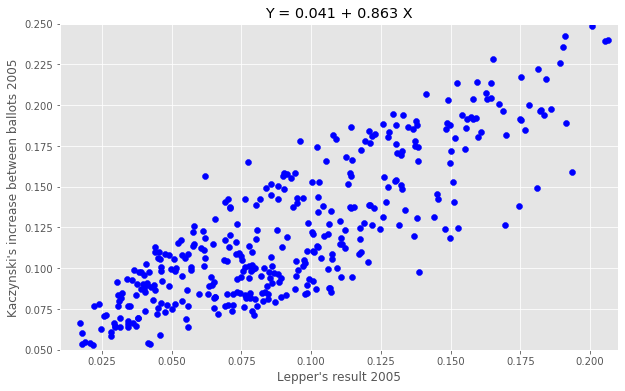

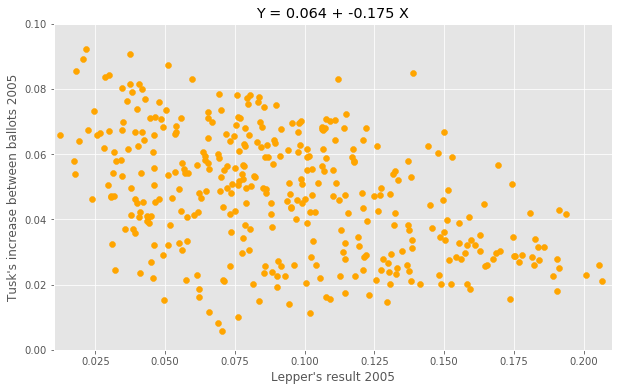

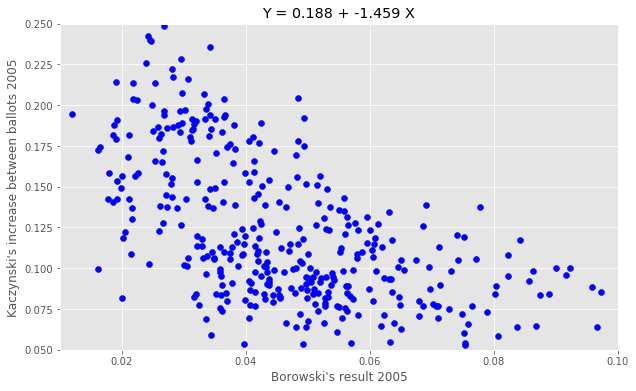

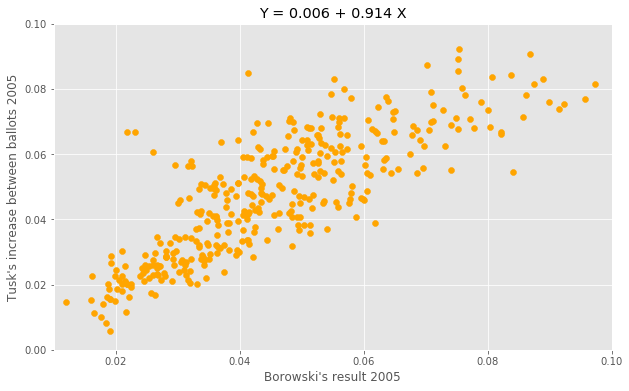

In [66]:
plt.figure(figsize=(10,6))
result_increase_reg("Kaczynski", "Lepper", 2005, xlim=(0.01, 0.21), ylim=(0.05, 0.25), normalized=False, color="blue")
plt.show()

plt.figure(figsize=(10,6))
result_increase_reg("Tusk", "Lepper", 2005, xlim=(0.01, 0.21), ylim=(0.0, 0.1), normalized=False, color="orange")
plt.show()

plt.figure(figsize=(10,6))
result_increase_reg("Kaczynski", "Borowski", 2005, xlim=(0.01, 0.1), ylim=(0.05, 0.25), normalized=False, color="blue")
plt.show()

plt.figure(figsize=(10,6))
result_increase_reg("Tusk", "Borowski", 2005, xlim=(0.01, 0.1), ylim=(0.0, 0.1), normalized=False, color="orange")
plt.show()

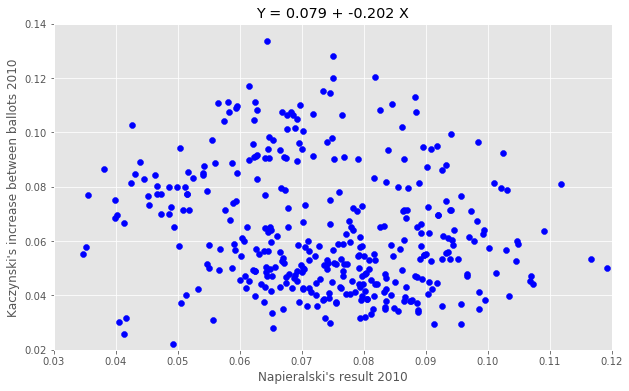

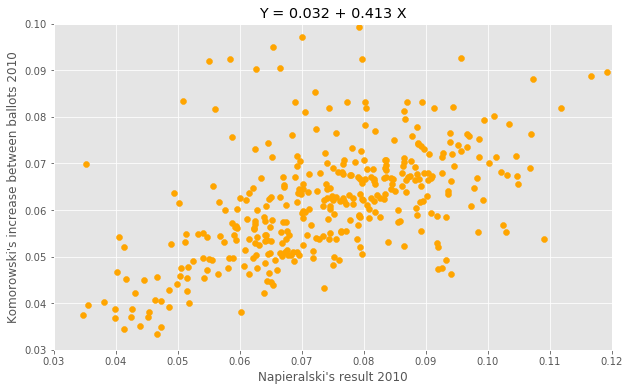

In [72]:
plt.figure(figsize=(10,6))
result_increase_reg("Kaczynski", "Napieralski", 2010, xlim=(0.03, 0.12), ylim=(0.02, 0.14), normalized=False, color="blue")
plt.show()

plt.figure(figsize=(10,6))
result_increase_reg("Komorowski", "Napieralski", 2010, xlim=(0.03, 0.12), ylim=(0.03, 0.10), normalized=False, color="orange")
plt.show()

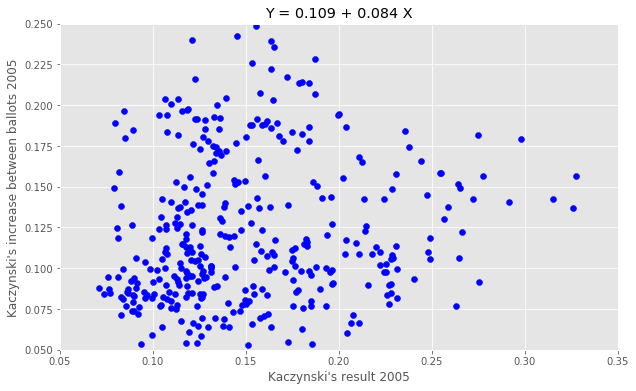

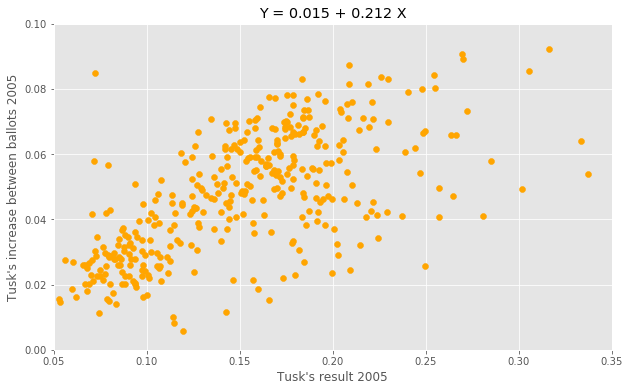

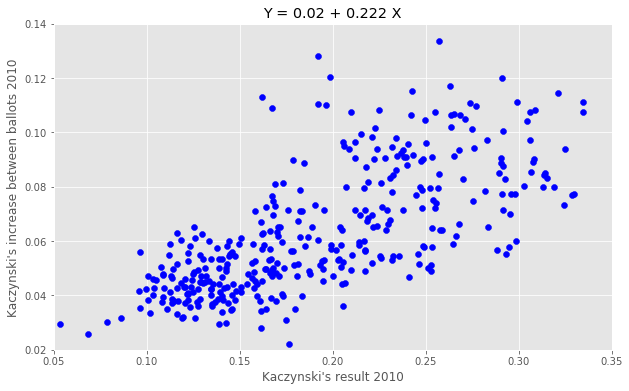

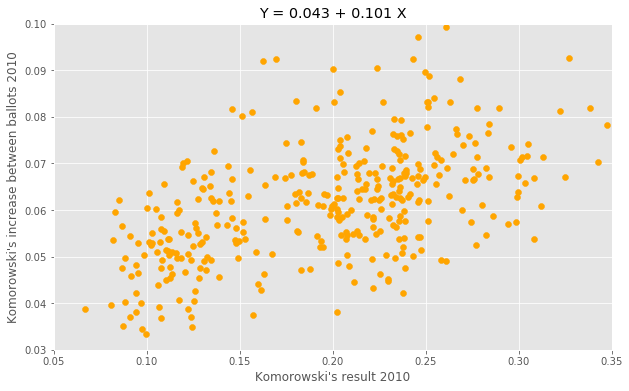

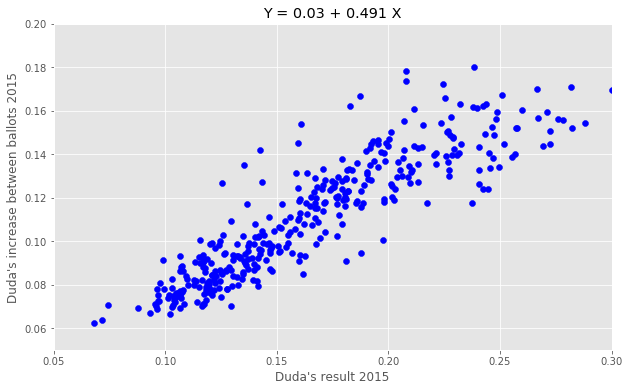

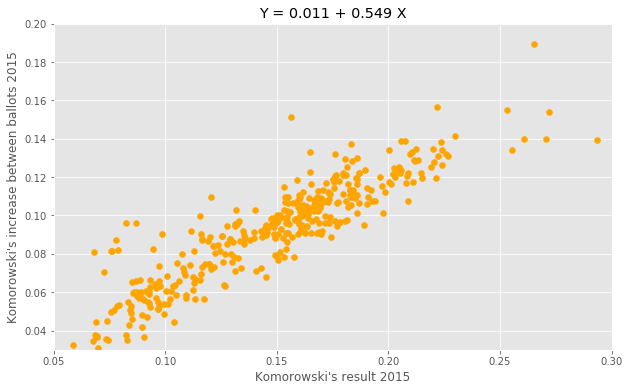

In [74]:
plt.figure(figsize=(10,6))
result_increase_reg("Kaczynski", "Kaczynski", 2005, xlim=(0.05, 0.35), ylim=(0.05, 0.25), normalized=False, color="blue")
plt.show()

plt.figure(figsize=(10,6))
result_increase_reg("Tusk", "Tusk", 2005, xlim=(0.05, 0.35), ylim=(0.0, 0.1), normalized=False, color="orange")
plt.show()

plt.figure(figsize=(10,6))
result_increase_reg("Kaczynski", "Kaczynski", 2010, xlim=(0.05, 0.35), ylim=(0.02, 0.14), normalized=False, color="blue")
plt.show()

plt.figure(figsize=(10,6))
result_increase_reg("Komorowski", "Komorowski", 2010, xlim=(0.05, 0.35), ylim=(0.03, 0.10), normalized=False, color="orange")
plt.show()

plt.figure(figsize=(10,6))
result_increase_reg("Duda", "Duda", 2015, xlim=(0.05, 0.3), ylim=(0.05, 0.2), normalized=False, color="blue")
plt.show()

plt.figure(figsize=(10,6))
result_increase_reg("Komorowski", "Komorowski", 2015, xlim=(0.05, 0.3), ylim=(0.03, 0.2), normalized=False, color="orange")
plt.show()